# Wide-field imaging demonstration

### This script makes a fake data set, fills it with a number of point components, and then images it. 

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import invert_2d, create_image_from_visibility, \
    weight_visibility, predict_skycomponent_visibility, create_w_term_image, invert_image_partition

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

doplot = True

### Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

### We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.arange(-numpy.pi / 4.0, +numpy.pi / 4.0, 0.25)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre)
uvw = vt.data['uvw']

create_visibility: Created 95865 rows


### Plot the synthesized UV coverage.

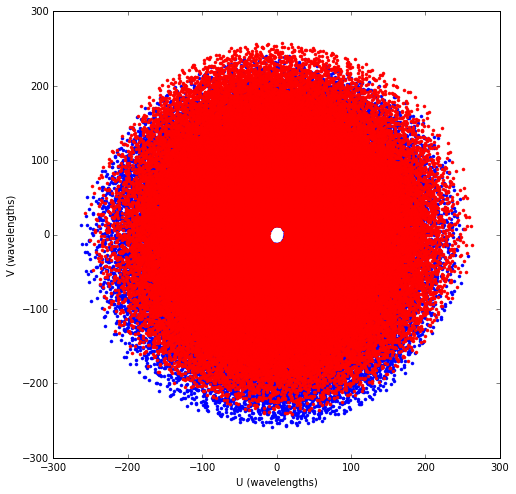

In [4]:
if doplot:
    plt.clf()
    for f in frequency:
        x = f / const.c
        plt.plot(x * vt.data['uvw'][:, 0], x * vt.data['uvw'][:, 1], '.', color='b')
        plt.plot(-x * vt.data['uvw'][:, 0], -x * vt.data['uvw'][:, 1], '.', color='r')
        plt.xlabel('U (wavelengths)')
        plt.ylabel('V (wavelengths)')

### Set up imaging parameters

In [5]:
params = {'npixel': 256,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated'}

### Look at the phase term due to w. Evaluate this for the median absolute w. 

ftprocessor.create_w_term_image: Creating w term image for median w 66.091375
fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.773578 lambda
create_wcs_from_visibility: Critical cellsize = 0.001903 radians, 0.109021 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.create_w_term_image: Fresnel number for median w and this field of view and sampling = 1.08


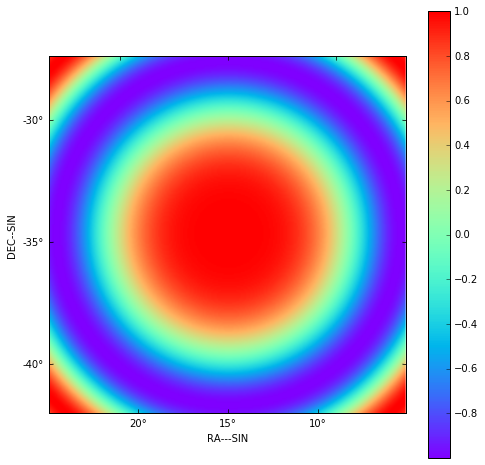

In [6]:
if doplot:
    wterm = create_w_term_image(vt, params=params)
    show_image(wterm)
    plt.show()

### Create a grid of components and predict each in turn, using the full phase term including w.

In [7]:
params = {'npixel': 256,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions':5}

flux = numpy.array([[100.0, 0.0, 0.0, 0.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, params=params)

spacing_pixels = params['npixel'] // params['image_partitions']
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * params['cellsize'] * spacing_pixels / numpy.pi
centers = -2.0, -1.0, 0.0, 1.0, 2.0
for iy in centers:
    for ix in centers:
        pra, pdec = params['npixel'] // 2 + ix * spacing_pixels,\
                    params['npixel'] // 2 + iy * spacing_pixels
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
        predict_skycomponent_visibility(vt, comp)

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.773578 lambda
create_wcs_from_visibility: Critical cellsize = 0.001903 radians, 0.109021 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 51
Component at (26.000000, 26.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (22.72355029, -40.62693525)>
fourier_transforms.predict_visibility: Cartesian representation of component = (0.102000, -0.102000, -0.010459)
Component at (77.000000, 26.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (18.8628933, -40.79753673)>
fourier_transforms.predict_visibility: Cartesian representation of component = (0.051000, -0.102000, -0.006524)
Component at (128.000000, 26.000000) <SkyCoord (ICRS): (ra, d

### Make the dirty image and point spread function. Note that the shape of the sources vary with position in the image. This space-variant property of the PSF arises from the w-term.

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.773578 lambda
create_wcs_from_visibility: Critical cellsize = 0.001903 radians, 0.109021 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.773578 lambda
create_wcs_from_visibility: Critical cellsize = 0.001903 radians, 0.109021 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
convolutional_gridding.weight_

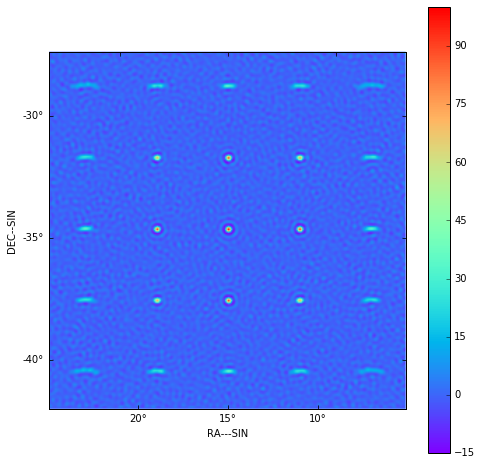

In [8]:
params = {'npixel': 256,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated'}

dirty = create_image_from_visibility(vt, params=params)
psf = create_image_from_visibility(vt, params=params)
vt = weight_visibility(vt, dirty)
dirty = invert_2d(vt, dirty, params=params)
psf = invert_2d(vt, dirty, dopsf=True, params=params)
psfmax = psf.data.max()
dirty.data = dirty.data / psfmax
psf.data = psf.data / psfmax

if doplot:
    show_image(dirty)

print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirty.data.max(), dirty.data.min(), psfmax))
print("Max, min in PSF = %.6f, %.6f, psfmax = %f" % (psf.data.max(), psf.data.min(), psfmax))

export_image_to_fits(dirty, 'imaging-wterm_dirty.fits')
export_image_to_fits(psf, 'imaging-wterm_psf.fits')

### Use image plane partitioning (faceting) to make the image

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.773578 lambda
create_wcs_from_visibility: Critical cellsize = 0.001903 radians, 0.109021 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.invert_image_partition: Two-dimensional invert using 5 x 5 image partitions
image_iterators.raster: partition 0 (0, 0) of 25
Pixel (25, 25) converts to direction <SkyCoord (ICRS): (ra, dec) in deg
    (22.80596392, -40.67982426)>
phaserotate_visibility: Relative cartesian representation of direction = (0.103000, -0.103000, -0.010666)
phaserotate: Phase rotation from <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)> to <SkyCoord (ICRS): (ra, dec) in deg
    (22.80596392, -40.67982426)>
ftprocess

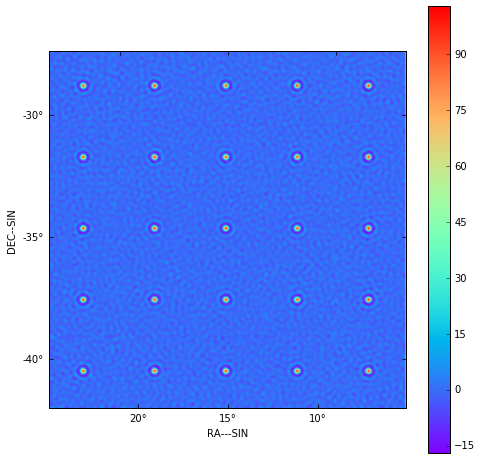

In [9]:
params = {'npixel': 256,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions': 5}


dirtyFacet = create_image_from_visibility(vt, params=params)
dirtyFacet = invert_image_partition(vt, dirtyFacet, params=params)
dirtyFacet.data = dirtyFacet.data / (psfmax * params['image_partitions'] * params['image_partitions'])

if doplot:
    show_image(dirtyFacet)

print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirtyFacet.data.max(), dirtyFacet.data.min(), psfmax))
export_image_to_fits(dirtyFacet, 'imaging-wterm_dirtyFacet.fits')

### That was the best case. This time, we will not arrange for the points to be at the center of the partitions.

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.773578 lambda
create_wcs_from_visibility: Critical cellsize = 0.001903 radians, 0.109021 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.invert_image_partition: Two-dimensional invert using 3 x 3 image partitions
image_iterators.raster: partition 0 (0, 0) of 9
Pixel (42, 42) converts to direction <SkyCoord (ICRS): (ra, dec) in deg
    (21.42462891, -39.77433834)>
phaserotate_visibility: Relative cartesian representation of direction = (0.086000, -0.086000, -0.007424)
phaserotate: Phase rotation from <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)> to <SkyCoord (ICRS): (ra, dec) in deg
    (21.42462891, -39.77433834)>
ftprocesso

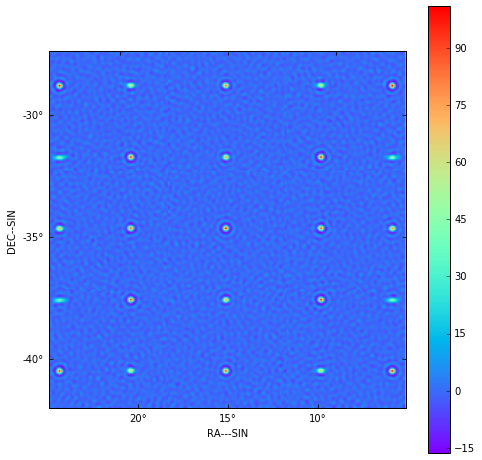

In [10]:
params = {'npixel': 256,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions':3}

dirtyFacet = create_image_from_visibility(vt, params=params)
dirtyFacet = invert_image_partition(vt, dirtyFacet, params=params)
dirtyFacet.data = dirtyFacet.data / (psfmax * params['image_partitions'] * params['image_partitions'])

if doplot:
    show_image(dirtyFacet)

print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirtyFacet.data.max(), dirtyFacet.data.min(), psfmax))
export_image_to_fits(dirtyFacet, 'imaging-wterm_dirtyFacet_3.fits')

### As expected at this moderate Fresnel number (16), a moderate number of facets leaves very substantial errors in the image. Now try w projection


fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15.0, -35.0)>, frequency 100000000.0 Hz, and bandwidth 50000000.0 Hz
create_wcs_from_visibility: uvmax = 262.773578 lambda
create_wcs_from_visibility: Critical cellsize = 0.001903 radians, 0.109021 degrees
create_wcs_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
ftprocessor.get_2d_params: Fresnel number = 16.384000
ftprocessor.get_2d_params: Recommended wstep = 0.971405
ftprocessor.get_2d_params: using w projection with wstep = 0.971405
ftprocessor.get_2d_params: w support = 64
variable_kernels.w_kernel_lambda: Cache miss on -5 * 0.971405
variable_kernels.w_kernel_lambda: Cache miss on 4 * 0.971405
variable_kernels.w_kernel_lambda: Cache miss on -13 * 0.971405
variable_kernels.w_kernel_lambda: Cache miss on -8 * 0.971405
variable_kernels.w_kernel_lambda: Cache miss on

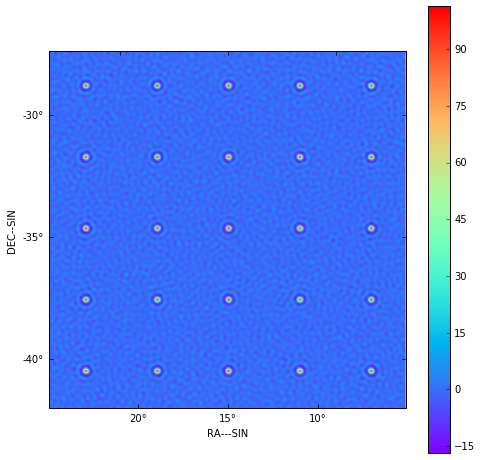

In [11]:
params = {'npixel': 256,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'wprojection'}

params['kernel']='wprojection'
dirtyWProjection = create_image_from_visibility(vt, params=params)
dirtyWProjection = invert_2d(vt, dirtyWProjection, params=params)
psfWProjection = create_image_from_visibility(vt, params=params)
psfWProjection = invert_2d(vt, psfWProjection, dopsf=True, params=params)
psfmax = psfWProjection.data.max()
dirtyWProjection.data = dirtyWProjection.data / psfmax
psfWProjection.data = psfWProjection.data / psfmax

if doplot:
    show_image(dirtyWProjection)

print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirtyWProjection.data.max(), 
                                                             dirtyWProjection.data.min(), psfmax))
export_image_to_fits(dirtyWProjection, 'imaging-wterm_dirty_WProjection.fits')
export_image_to_fits(psfWProjection, 'imaging-wterm_psf_WProjection.fits')